# Repsol - Compressor Predictive Maintenance Case

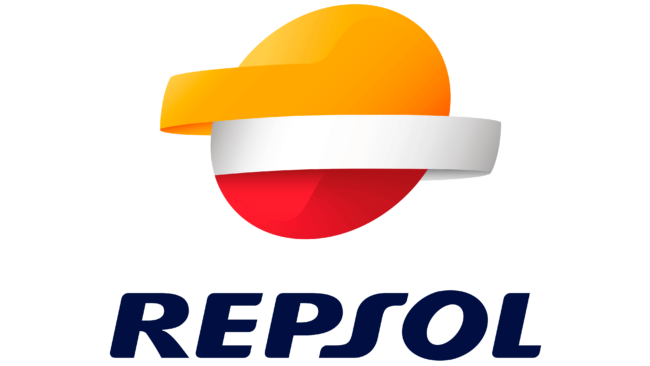

# Introduction

The objective of this project is to identify anomalies with sensor data to allow Repsol to minimize supply chain disruption caused by compressor breakdown and maximize gas pipeline capacity in production.

For this challenge the team was provided with historical data of the compressor´s main operating variables, with the objective of detecting, in an unsupervised way, anomalies in the operation that may lead to an unwanted shutdown. 

The data provided included features of motor and compressor measures with a predefined time frame set as Training and as other set as Test data. Training data was also predefined as normal behavioral historical data and Test data was known to be the abnormal behavioral period.

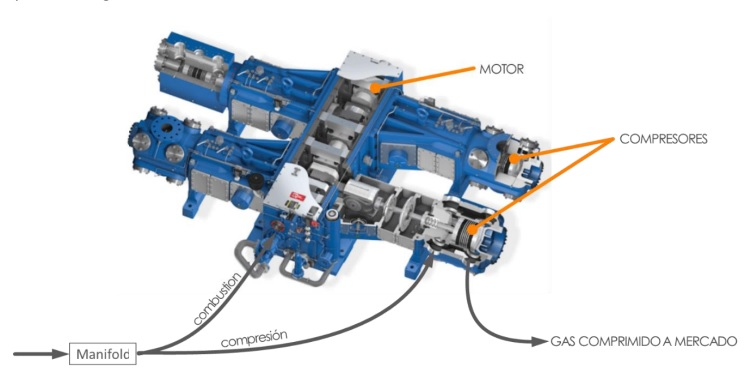

# Importing the libraries and the data set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
import sklearn
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import missingno as msno
import warnings
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from scipy.spatial.distance import cdist

In [2]:
warnings.filterwarnings('ignore') # Do not print warning messages

In [3]:
sklearn.set_config(display='diagram') # Better display of the pipelines

In [4]:
df = pd.read_csv('datos.csv', sep='|', on_bad_lines='skip', parse_dates=['datetime'], index_col='datetime')

# Exploratory Data Analysis

First let's analyze basic information about the data. We are going to see the **statistics**, the **distribution plot**, the **time series plot** and the **correlation matrix** of the variables.

In [5]:
df.shape

(18361, 59)

In [6]:
df.describe()

,K-1303_Engine_RPM,K-1303_Engine_Load_Factor,K-1303_Fuel_Gas_Pressure,K-1303_Pre_Catalyst_Temperature,K-1303_Post_Catalyst_Temperature,K-1303_Actual_Engine_Timing,K-1303_Inlet_Air_Temperature,K-1303_Fuel_Pressure_-_Absolute,K-1303_Engine_Fuel_Gas_Temperature,K-1303_Fuel_Valve_Position,...,K-1303_Suction_Screen_Differential_Pressure,K-1303_Stage_#1_Suction_Temperature,K-1303_Cylinder_#1_Temperature,K-1303_Stage_#2_Suction_Temperature,K-1303_Cylinder_#2_Temperature,K-1303_Stage_#3_Suction_Temperature,K-1303_Cylinder_#3_Temperature,K-1303_Cylinder_#4_Temperature,Train_1_Inlet_Separator_Pressure,Train_1_Sales_Pressure
count,18064.000000,18064.000000,18064.000000,18064.000000,18064.000000,18064.000000,18064.000000,18064.000000,18062.000000,18064.000000,...,18064.000000,18064.000000,18064.000000,18102.000000,18064.000000,18064.000000,18064.000000,18064.000000,8864.000000,305.000000
mean,1307.652624,76.494852,31.217333,891.583426,803.715954,26.683996,145.132007,16.879167,67.548854,38.842504,...,0.219492,50.847487,166.321523,96.088278,214.585861,91.950565,164.222487,225.675321,129.403683,1166.633326
std,235.247624,10.559201,3.794971,154.800916,143.202942,2.898937,9.765803,0.601502,15.348331,5.087252,...,0.444181,23.191016,69.298882,23.229248,36.004377,26.686883,15.983648,34.028685,7.088857,15.997491
min,0.000000,0.000000,27.299999,63.000000,0.000000,0.000000,61.520000,13.561050,35.599998,0.000000,...,0.000000,19.000000,0.000000,53.000000,-102.000000,0.000000,57.000000,0.000000,0.559280,1057.113037
25%,1305.500000,74.000000,30.299999,919.000000,832.000000,24.700001,136.940002,16.896931,59.000000,39.000000,...,0.100000,44.000000,162.000000,90.000000,212.000000,81.000000,160.000000,224.000000,127.332100,1167.349976
50%,1351.500000,78.000000,31.100000,926.000000,834.000000,27.000000,144.500000,16.969450,62.599998,40.000000,...,0.100000,47.000000,163.000000,95.000000,220.000000,90.000000,162.000000,235.000000,128.454895,1170.441040
75%,1397.000000,82.000000,31.600000,928.000000,840.000000,29.200001,149.720001,17.114479,73.400002,41.000000,...,0.200000,58.000000,172.000000,102.000000,231.000000,103.000000,171.000000,238.000000,130.202896,1173.150024
max,1430.000000,95.000000,100.199997,1043.000000,891.000000,29.700001,200.000000,17.332041,149.000000,100.000000,...,8.500000,2936.000000,2052.000000,2930.000000,261.000000,2935.000000,202.000000,268.000000,298.199799,1176.859985


We can see that the data is in general close to the mean for each sensor. Nontheless, some sensors have registered very extreme values, sometimes more than 50 standar deviations away from the mean.

In [7]:
df.isna().sum()

K-1303_Engine_RPM                                                 297
K-1303_Engine_Load_Factor                                         297
K-1303_Fuel_Gas_Pressure                                          297
K-1303_Pre_Catalyst_Temperature                                   297
K-1303_Post_Catalyst_Temperature                                  297
K-1303_Actual_Engine_Timing                                       297
K-1303_Inlet_Air_Temperature                                      297
K-1303_Fuel_Pressure_-_Absolute                                   297
K-1303_Engine_Fuel_Gas_Temperature                                299
K-1303_Fuel_Valve_Position                                        297
K-1303_Actual_Air_to_Fuel_Ratio                                   297
K-1303_Fuel_Valve_Differential_Pressure                           297
K-1303_Left_Bank_Turbine_Inlet_Temperature                        297
K-1303_Left_Bank_Turbine_Outlet_Temperature                       274
K-1303_Right_Bank_Tu

The sensors share a similar number of missing values, with the exception of two columns that have many more in comparison.

<AxesSubplot:xlabel='datetime'>

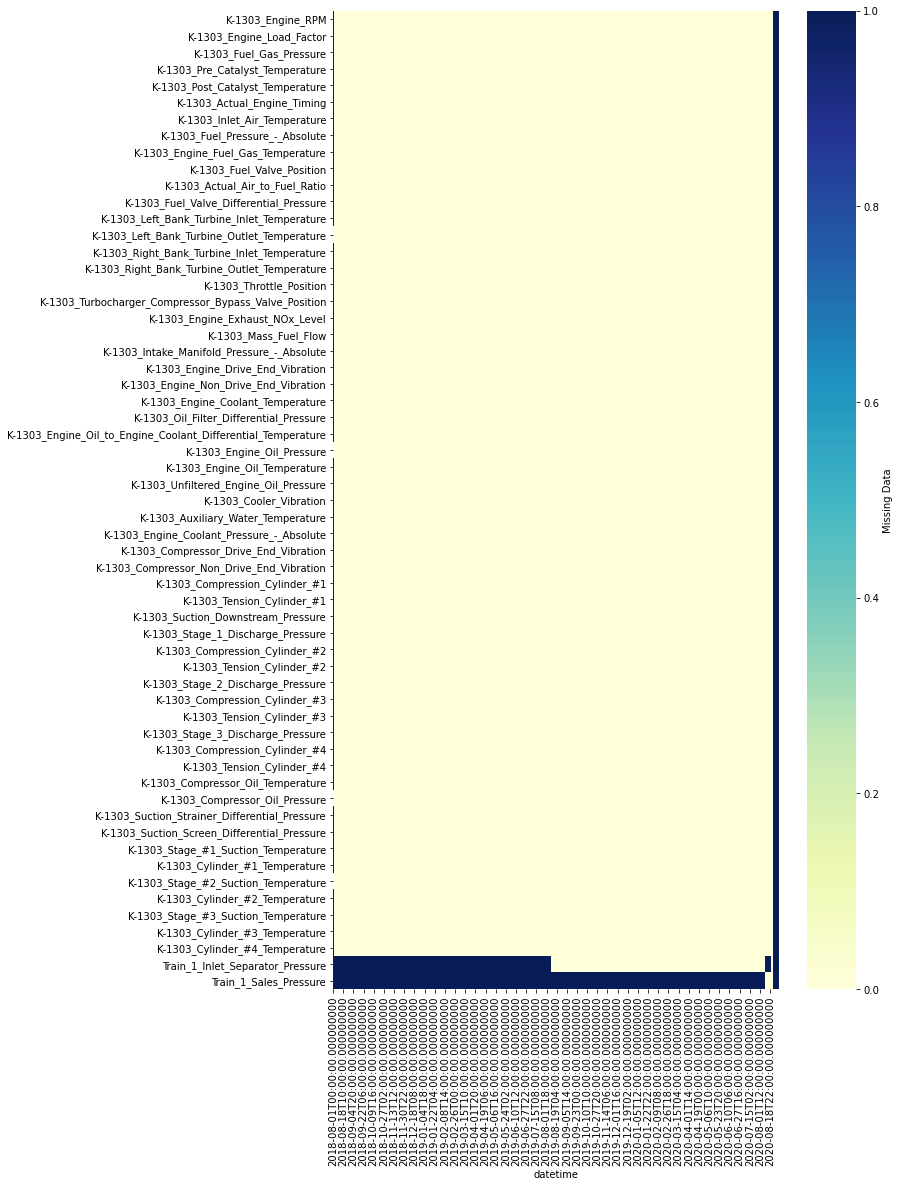

In [8]:
plt.figure(figsize=(10,18))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

It seems there are no structural missing values. The existing ones could be due sensors that are turned off at the begining and end of the periods.

In consequence, we are going to drop the rows containing the missing values.

Just the columns "Train_1_Sales_Pressure" and "Train_1_Inlet_Separator_Pressure" show a disproportional number of missing values, so they are going to be dropped.

In [9]:
df.drop(columns=['Train_1_Sales_Pressure', 'Train_1_Inlet_Separator_Pressure'], inplace=True)
df.dropna(inplace=True)

We are going to filter and split the variables related to the motor and the compressor for further analysis and analytical purposes, but we are going to apply the models to the variables together.

We also are going to separate the data in the corresponding two periods:

- **Train set**: period without anomalies.
- **Test**: period where we need to detect the real anomalies.

In [10]:
motor = df[['K-1303_Engine_RPM',
'K-1303_Engine_Drive_End_Vibration',
'K-1303_Engine_Non_Drive_End_Vibration',
'K-1303_Engine_Load_Factor',
'K-1303_Engine_Coolant_Temperature',
'K-1303_Oil_Filter_Differential_Pressure',
'K-1303_Engine_Oil_to_Engine_Coolant_Differential_Temperature',
'K-1303_Engine_Oil_Pressure',
'K-1303_Engine_Oil_Temperature',
'K-1303_Inlet_Air_Temperature',
'K-1303_Unfiltered_Engine_Oil_Pressure',
'K-1303_Intake_Manifold_Pressure_-_Absolute',
'K-1303_Cooler_Vibration',
'K-1303_Auxiliary_Water_Temperature',
'K-1303_Engine_Coolant_Pressure_-_Absolute']]

compressor = df[['K-1303_Engine_RPM',
'K-1303_Engine_Load_Factor',
'K-1303_Compressor_Drive_End_Vibration',
'K-1303_Compressor_Non_Drive_End_Vibration',
'K-1303_Compression_Cylinder_#1',
'K-1303_Tension_Cylinder_#1',
'K-1303_Suction_Downstream_Pressure',
'K-1303_Stage_1_Discharge_Pressure',
'K-1303_Compression_Cylinder_#2',
'K-1303_Tension_Cylinder_#2',
'K-1303_Stage_2_Discharge_Pressure',
'K-1303_Compression_Cylinder_#3',
'K-1303_Tension_Cylinder_#3',
'K-1303_Stage_3_Discharge_Pressure',
'K-1303_Compression_Cylinder_#4',
'K-1303_Tension_Cylinder_#4',
'K-1303_Compressor_Oil_Temperature',
'K-1303_Compressor_Oil_Pressure',
'K-1303_Inlet_Air_Temperature',
'K-1303_Auxiliary_Water_Temperature']]

In [11]:
df_cm = pd.merge(motor, compressor, right_index=True, left_index=True)

train = df_cm.loc['2019-09-05':'2020-09-04']
test = df_cm.loc['2018-08-01':'2019-04-01']

## Train set

In [12]:
train.describe()

,K-1303_Engine_RPM_x,K-1303_Engine_Drive_End_Vibration,K-1303_Engine_Non_Drive_End_Vibration,K-1303_Engine_Load_Factor_x,K-1303_Engine_Coolant_Temperature,K-1303_Oil_Filter_Differential_Pressure,K-1303_Engine_Oil_to_Engine_Coolant_Differential_Temperature,K-1303_Engine_Oil_Pressure,K-1303_Engine_Oil_Temperature,K-1303_Inlet_Air_Temperature_x,...,K-1303_Stage_2_Discharge_Pressure,K-1303_Compression_Cylinder_#3,K-1303_Tension_Cylinder_#3,K-1303_Stage_3_Discharge_Pressure,K-1303_Compression_Cylinder_#4,K-1303_Tension_Cylinder_#4,K-1303_Compressor_Oil_Temperature,K-1303_Compressor_Oil_Pressure,K-1303_Inlet_Air_Temperature_y,K-1303_Auxiliary_Water_Temperature_y
count,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,...,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.00000
mean,1299.227241,0.402971,0.375847,75.513879,193.739589,13.082498,28.769160,65.750893,191.535427,148.332322,...,556.136709,378.247471,12409.769466,1194.528134,22723.822630,20463.176900,168.269231,63.150976,148.332322,121.02423
std,229.455218,0.047160,0.052721,14.010608,8.626867,1.106816,7.720517,5.420120,8.919369,9.827804,...,113.315021,53.016176,2521.571462,310.733419,5764.451832,4804.072118,14.652420,13.235697,9.827804,23.39931
min,0.000000,0.000000,0.000000,0.000000,73.400002,0.000000,-100.000000,0.000000,84.199997,61.520000,...,0.000000,0.000000,-510.000000,2.500000,-710.000000,-1410.000000,-111.000000,0.000000,61.520000,61.00000
25%,1256.500000,0.380000,0.340000,71.000000,190.399994,12.690830,30.200001,65.339622,190.399994,143.240005,...,547.000000,370.000000,12320.000000,1227.800049,21890.000000,19450.000000,167.250000,65.000000,143.240005,116.00000
50%,1371.000000,0.410000,0.390000,80.000000,192.199997,13.198460,30.200001,66.282356,192.199997,147.559998,...,596.900024,380.000000,13110.000000,1292.500000,24470.000000,21770.000000,170.000000,66.000000,147.559998,122.00000
75%,1395.000000,0.430000,0.410000,84.000000,195.800003,13.633570,32.000000,67.297630,195.800003,152.240005,...,608.000000,390.000000,13490.000000,1335.000000,25000.000000,22270.000000,173.000000,66.699997,152.240005,127.00000
max,1430.000000,0.530000,0.630000,95.000000,217.399994,16.606850,53.599998,87.312866,215.600006,200.000000,...,729.900024,890.000000,14590.000000,1350.300049,36580.000000,34550.000000,188.000000,81.800003,200.000000,2052.00000


The data in the following plots in this sections will be scaled with a robust scaler using the median.

In [13]:
robust = RobustScaler()

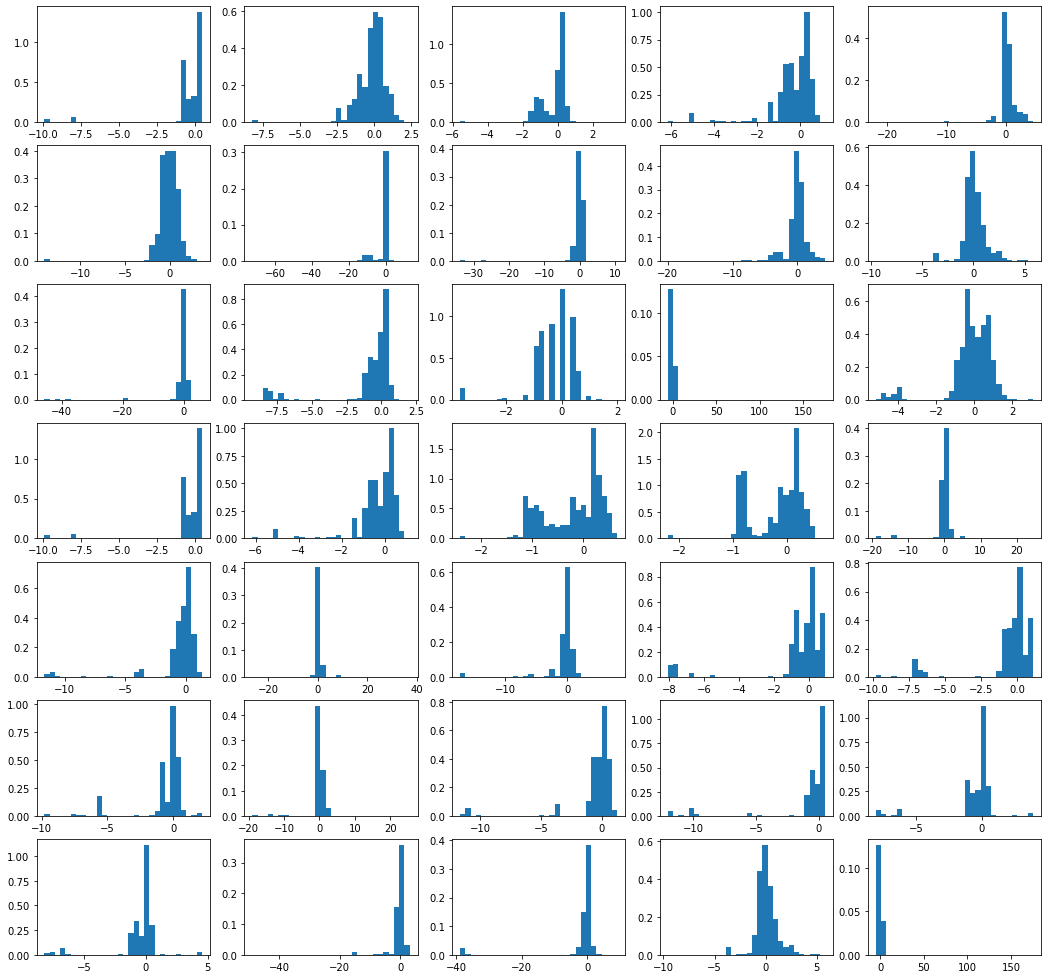

In [14]:
histograms = pd.DataFrame(robust.fit_transform(train))

fig, axes = plt.subplots(8, 5, figsize=(18, 20))
for i, ax in enumerate(axes.ravel()):
    if i >= histograms.shape[1]:
        ax.set_visible(False)
        continue
    ax.hist(histograms.iloc[:, i], bins=30, density=True)

Many of the columns shows a bimodal distribution with a high number of extreme values.

Text(0.5, 1.0, 'Train')

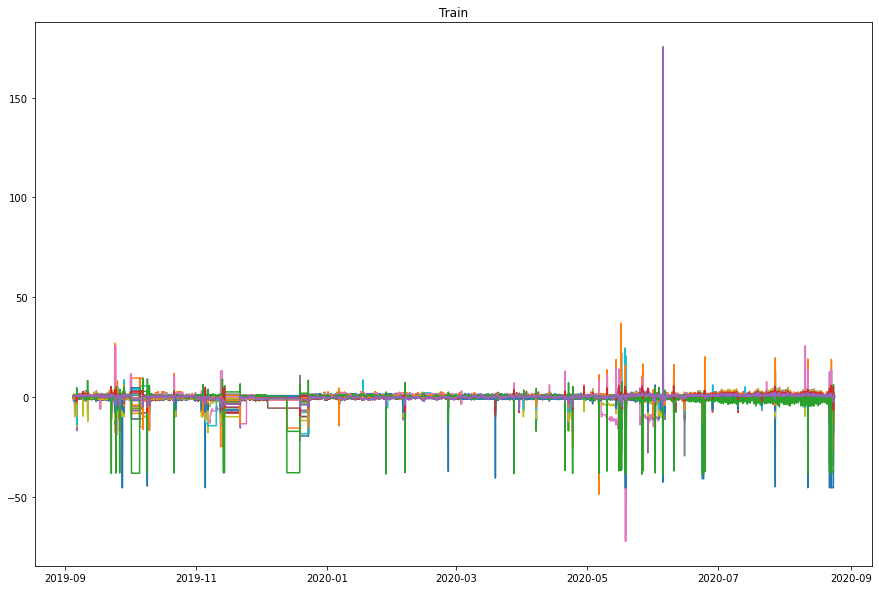

In [15]:
plt.figure(figsize=(15,10))
plt.plot(train.index, robust.fit_transform(train))
plt.title('Train')

Even though we are analysing the period withouth anomalies, we can still detect extreme values that are many standard deviations away from the mean and the median.

## Test set

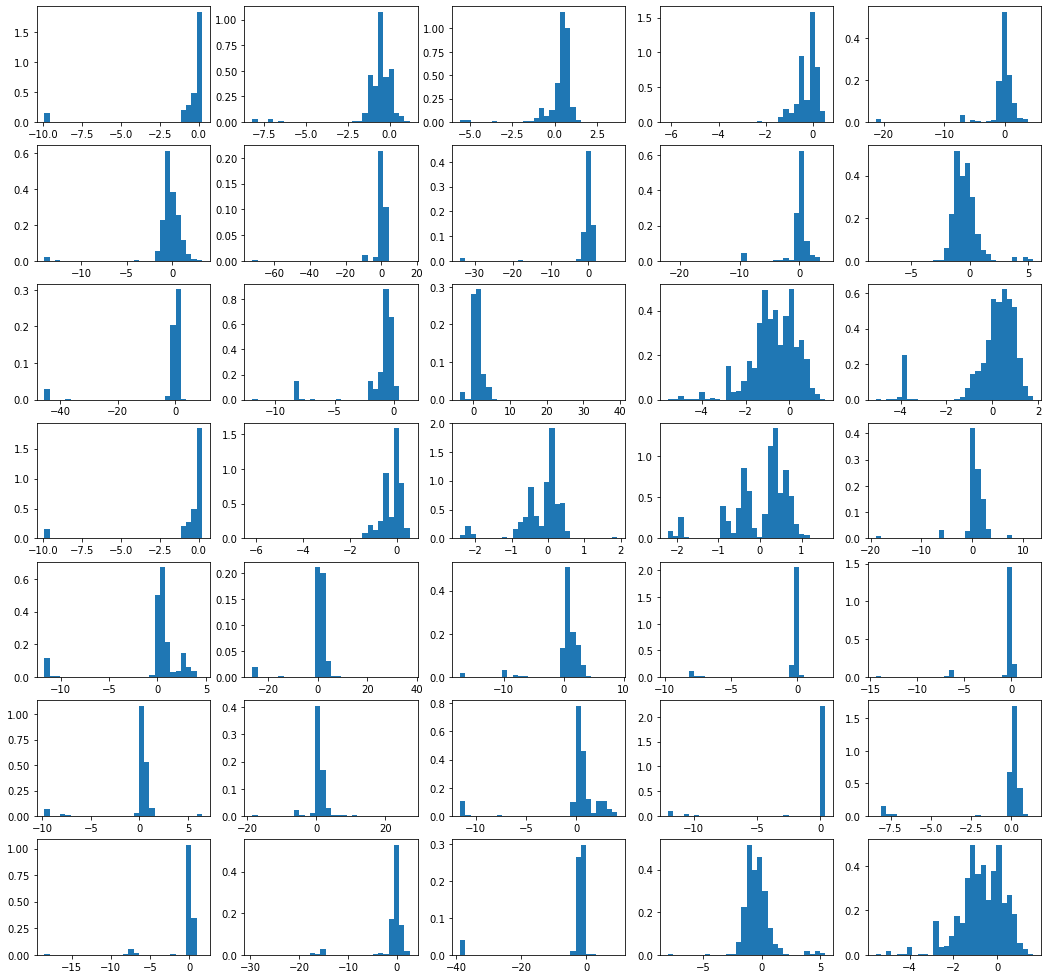

In [16]:
histograms = pd.DataFrame(robust.transform(test))

fig, axes = plt.subplots(8, 5, figsize=(18, 20))
for i, ax in enumerate(axes.ravel()):
    if i >= histograms.shape[1]:
        ax.set_visible(False)
        continue
    ax.hist(histograms.iloc[:, i], bins=30, density=True)

In the test set we can also see a bimodal behavior in the distributions and the presence of extreme values

Text(0.5, 1.0, 'Test')

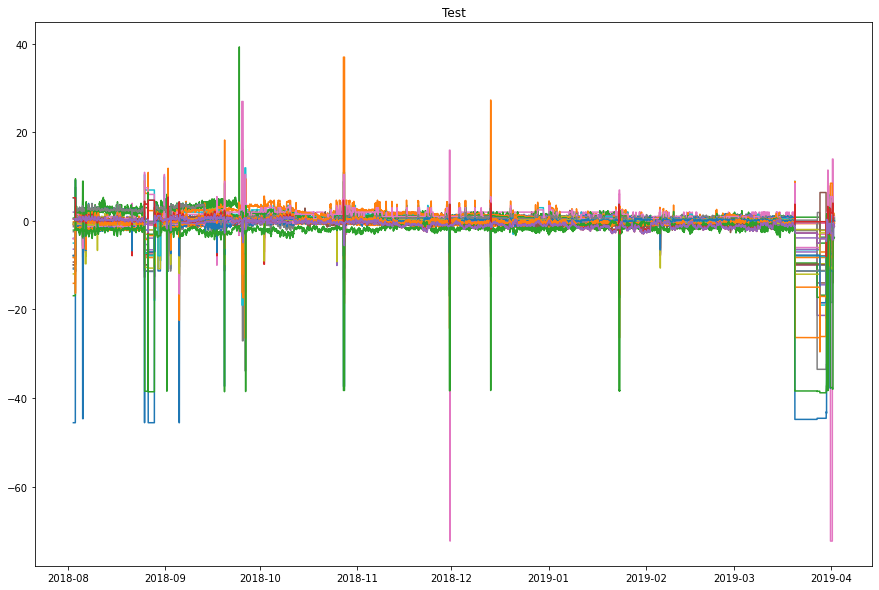

In [17]:
plt.figure(figsize=(15,10))
plt.plot(test.index, robust.transform(test))
plt.title('Test')

We can spot the presence of extreme values in the the time series plot of the test set.

Later, we are going to apply different models to detect where are the relevant anomalies in the machine and not just extreme values in some sensors.

# Outlier handling

We need to deal with the outliers taking into consideration a multi-dimensional context and not just a simple statistical measure.

In the real life, it is possible to have extreme values registered in the sensors and not having a real problem with the machines. In this sense, we are going to train the models taking into consideration these extreme values without changing their values, and just labeling them as outliers.

To achieve this goal, we are going to train a Isolation Forest model to detect the outliers in the train set, and label them in a new categorical feature.

This way, Isolation Forest detects anomalies calculating how far an observation is from the rest of the data, instead of modelling the normal points.

In [18]:
simple = SimpleImputer(strategy='median')

In [19]:
random_state = 13 # For reproducibility of the notebook

In [20]:
def isolation_outliers(X):
    outliers = IsolationForest(contamination=0.01, random_state=random_state).fit_predict(X)
    return np.column_stack([X, outliers])
function_isolation = FunctionTransformer(isolation_outliers)

Before training the model, we built a pipeline to impute the missing values with the median and normalize the data with a robust scaler (also using the median).

In [21]:
outliers_pipeline = Pipeline([
    ('imputer', simple),
    ('scaler', robust),
    ('model', function_isolation)
])
outliers_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('model',
                 FunctionTransformer(func=<function isolation_outliers at 0x0000025CD9C3BA60>))])

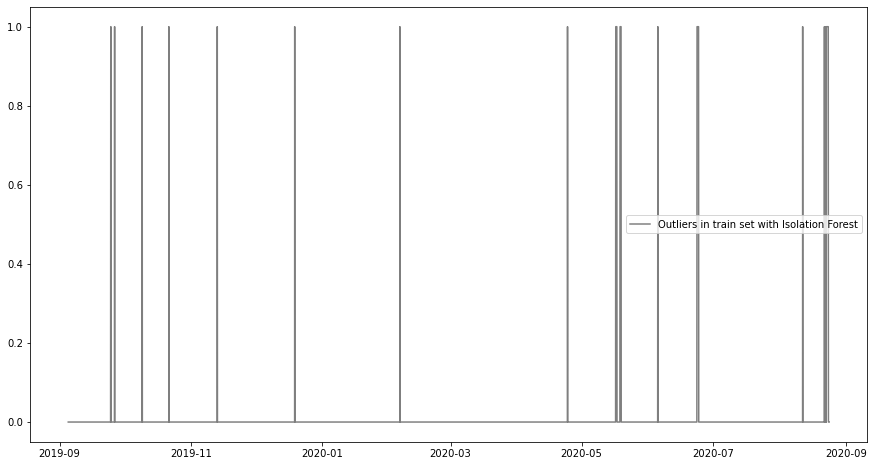

In [22]:
outliers_pipeline.fit(train)

isol_pred_train = pd.DataFrame(outliers_pipeline.transform(train)).replace(1,0).replace(-1,1).set_index(train.index)

plt.figure(figsize=(15,8))
plt.plot(isol_pred_train.iloc[:,-1], color='black', alpha=0.5, label='Outliers in train set with Isolation Forest')

plt.legend()

plt.show()


Here we can observe the detected outliers through time in the train set.

# Correlation analysis

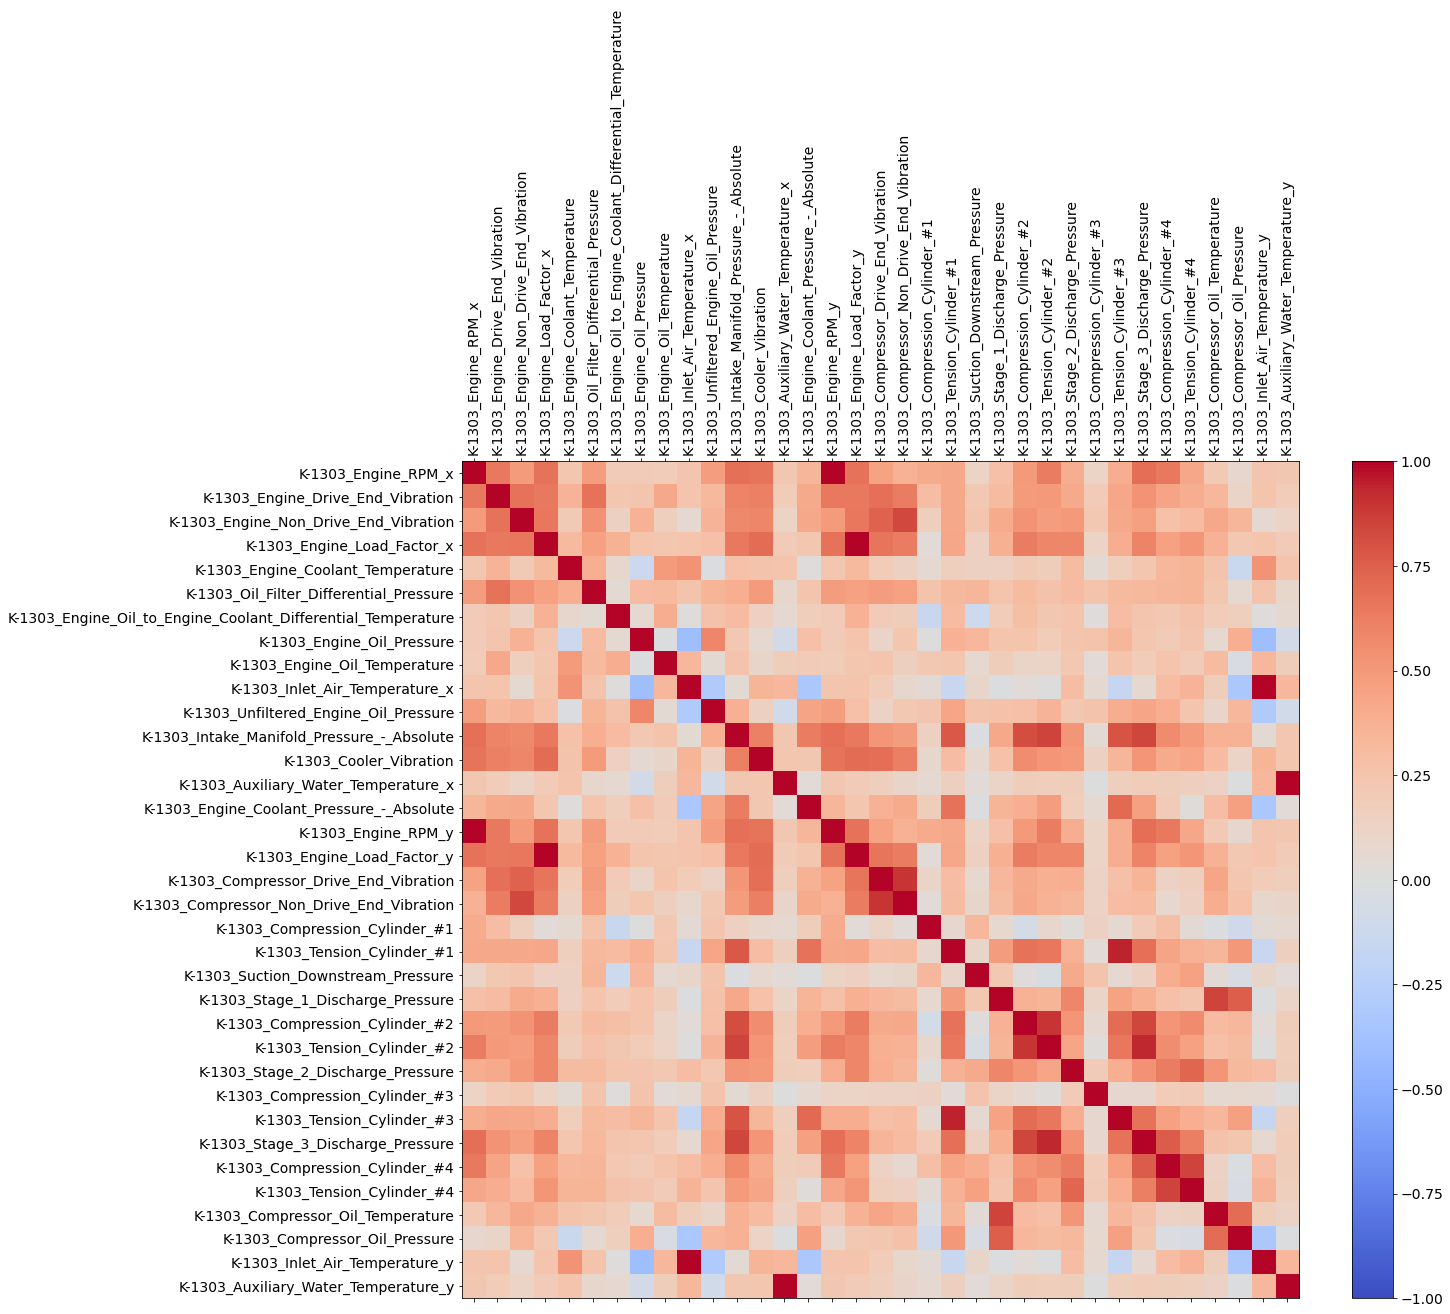

In [23]:
f = plt.figure(figsize=(19, 15))
plt.matshow(train.corr(), fignum=f.number, cmap=plt.cm.coolwarm, vmin = -1, vmax = 1)
plt.xticks(range(train.shape[1]), train.columns, fontsize=14, rotation=90)
plt.yticks(range(train.shape[1]), train.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

Many of the features are positively correlated.

In order to train the model with uncorrelated variables, we are going to apply Principal Component Analysis (PCA).

# Principal Component Analysis

Since we have many dimensions in our data set, and many of the features are highly correlated, we are going to use the Principal Component Analysis (PCA) for dimensionality reduction by projecting each data point onto some of the principal components to have the data with less dimensions and preserving as much of the data's variance as possible.

We are going to build a pipeline on top of the previous one to apply the PCA.

The PCA algorithm is going to be trained with the Train set.

In [24]:
pca = PCA()

In [25]:
pca_pipeline = Pipeline([
    ('preprocessing', outliers_pipeline),   
    ('pca', pca)
])
pca_pipeline

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', RobustScaler()),
                                 ('model',
                                  FunctionTransformer(func=<function isolation_outliers at 0x0000025CD9C3BA60>))])),
                ('pca', PCA())])

In [26]:
pc_train = pd.DataFrame(pca_pipeline.fit_transform(train))
var = pd.DataFrame(pca.explained_variance_ratio_)
pca_cum = np.cumsum(var)

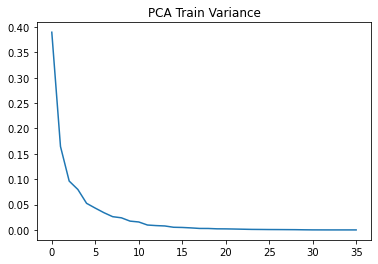

Text(0.5, 1.0, 'PCA Train Variance Cummulative')

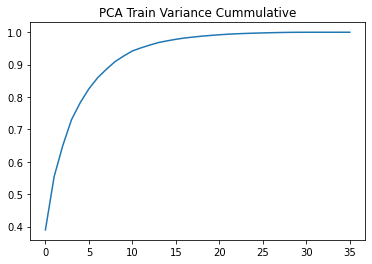

In [27]:
plt.plot(var)
plt.title('PCA Train Variance')
plt.show()

plt.plot(pca_cum)
plt.title('PCA Train Variance Cummulative')

In [28]:
pca_cum.head(10)

,0
0,0.389602
1,0.554029
2,0.650303
3,0.729974
4,0.782391
5,0.825341
6,0.859263
7,0.885357
8,0.909232
9,0.926562


Later, we are going to train the models using 9 Principal Components, that explain the variance of the data in more than 90%.

In [29]:
pc_test = pd.DataFrame(pca_pipeline.transform(test))

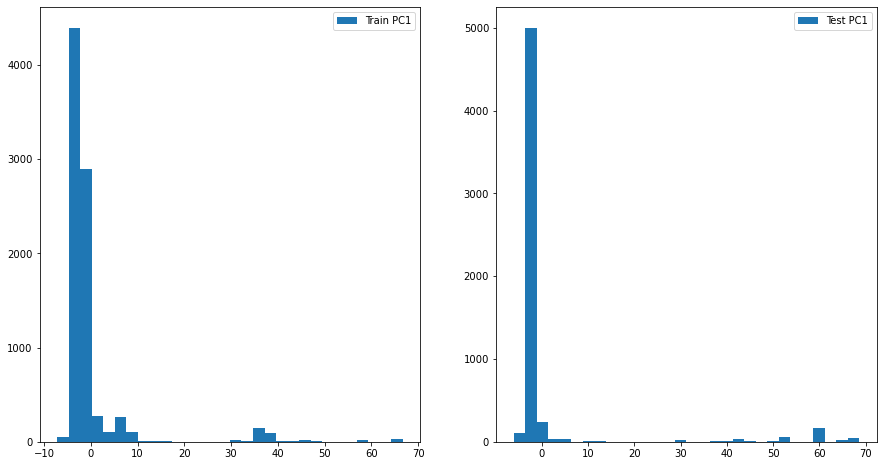

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax[0].hist(pc_train[0], bins=30, label='Train PC1')
ax[1].hist(pc_test[0], bins=30, label ='Test PC1')
ax[0].legend()
ax[1].legend()

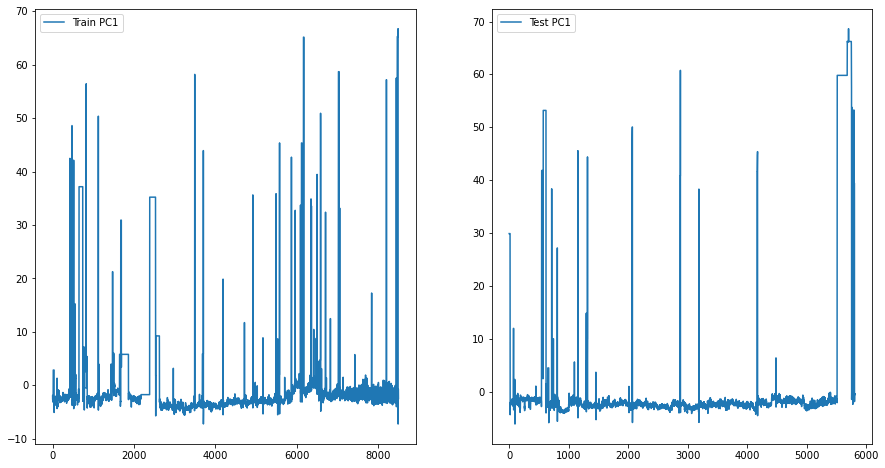

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax[0].plot(pc_train[0], label='Train PC1')
ax[1].plot(pc_test[0], label ='Test PC1')
ax[0].legend()
ax[1].legend()

Ploting the distribution and time series of the first PC does not seem enough to spot anomalies in the test set, since both contain extreme values in many moments.

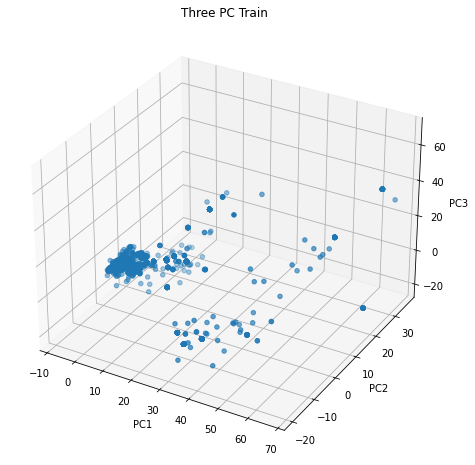

Text(0.5, 0, 'PC3')

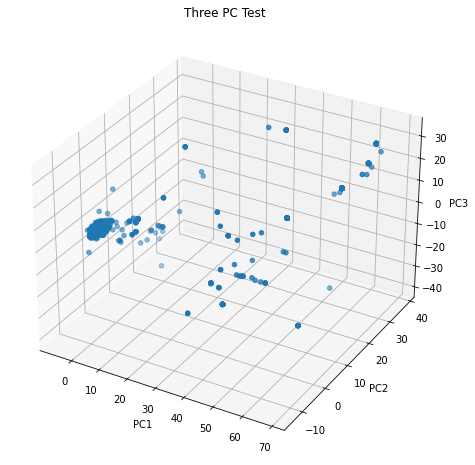

In [32]:
fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection ='3d')
ax.scatter(pc_train[0], pc_train[1], pc_train[2])

plt.title('Three PC Train')
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection ='3d')
ax.scatter(pc_test[0], pc_test[1], pc_test[2])

plt.title('Three PC Test')
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.set_zlabel('PC3')

Between the train and test sets, we can spot some differences in the visualization of the points with three PCs. 

Furthermore, we will study if a K-means model can be useful to detect anomalous behaviour.

# Unsupervised model

## K-means

We are going to train a k-means algorithm to detect the natural groups in the entire dataset, using 9 Principal Components. In this sense, this model is going to be fully unsupervised, since we are considering the entire data set without distinction between the normal and the irregular period.

Finally, with the model trained, we are going to label the anomalies in the test set, where we know the real anomalies occured.

The main goal is to detect the clusters of observations with the anomalies, based on the distance from the other clusters.

Nontheless, before training the algorithm, we will try to find the optimal number of clusters needed to segment the data. Considering the multi-dimensional nature of the data, it is not accurate to base this number on the graphical representation of the observations. Thus, it is going to be useful to apply the Elbow Method and Inertia, which calculates the sum of squared distances of the observations to their closest cluster center.

Furthermore, we will iterate over 1 to 9 k values and calculate the distortions and inertia for each one.

In this sense, with this method we are going to show how increasing the number of the clusters adds value separating the clusters in a meaningful way, not in a marginal way.

In [33]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_cm)
    kmeanModel.fit(df_cm)
  
    distortions.append(sum(np.min(cdist(df_cm, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / df_cm.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(df_cm, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / df_cm.shape[0]
    mapping2[k] = kmeanModel.inertia_

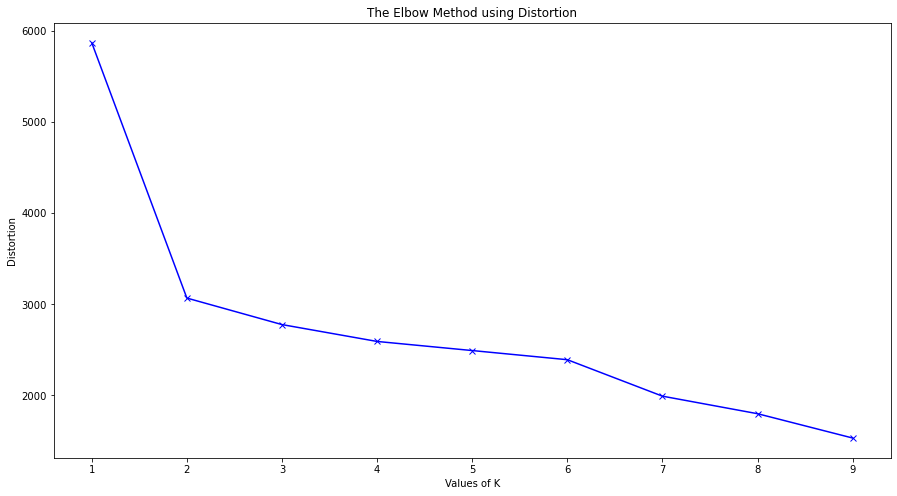

In [34]:
plt.figure(figsize=(15,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

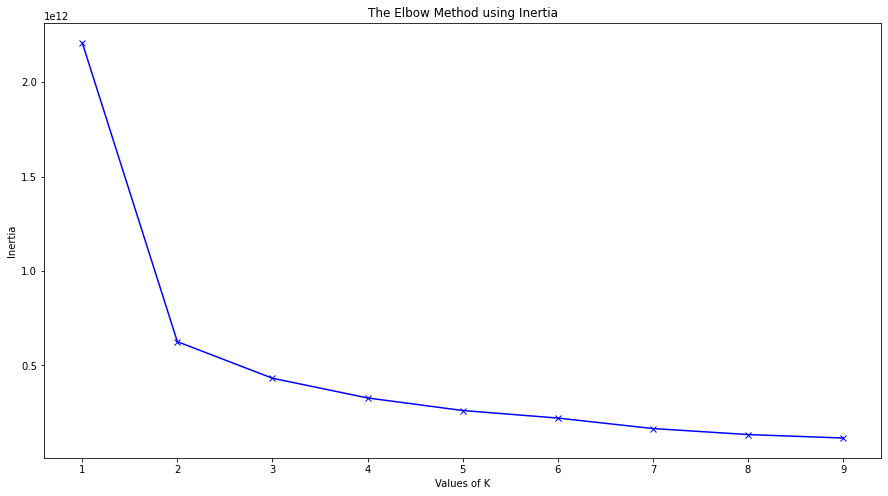

In [35]:
plt.figure(figsize=(15,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

To determine the optimal number of clusters, we should select the k in the value after which the distortion and the inertia start to decrease in a linear way.

Based on this criteria, it is clear from the two graphs that we should select 2 clusters for the model. However, considering the anomalous nature of the observations that we want to classify as potential problems, adding an extra cluster could be convenient to detect this group, even though this adds marginal value based on the Elbow Method.

In [36]:
pc_full = pd.DataFrame(pca_pipeline.fit_transform(df_cm))

kmeans = KMeans(n_clusters=3, random_state=random_state)

In [37]:
kmeans_pipeline = Pipeline([
    ('preprocessing', pca_pipeline),
    ('kmeans', kmeans)
])
kmeans_pipeline

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('scaler', RobustScaler()),
                                                  ('model',
                                                   FunctionTransformer(func=<function isolation_outliers at 0x0000025CD9C3BA60>))])),
                                 ('pca', PCA())])),
                ('kmeans', KMeans(n_clusters=3, random_state=13))])

The pipeline is built on top of the preprocessing ones.

Text(0.5, 0, 'PC3')

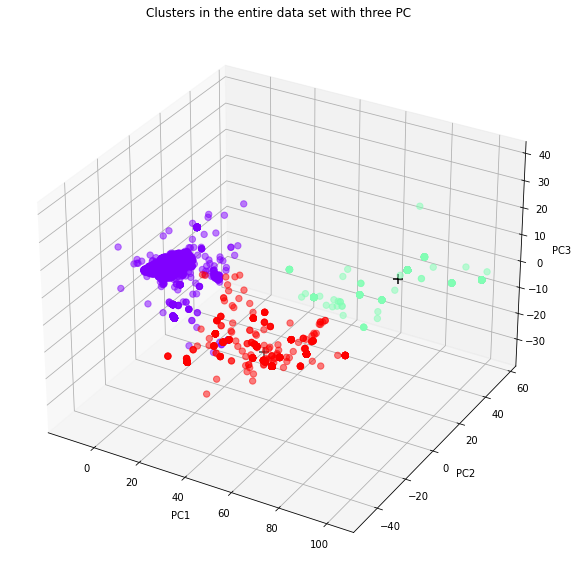

In [38]:
kmeans_pipeline.fit(df_cm)
pc_full['label'] = kmeans.labels_

fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection ='3d')
ax.scatter(pc_full[0], pc_full[1], pc_full[2], c=pc_full['label'], cmap='rainbow', s = 40, marker = 'o',alpha = 0.5)
ax.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,2], color='black', marker = '+', s = 100)

plt.title('Clusters in the entire data set with three PC')
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.set_zlabel('PC3')

Even tough the model was trained with 9 Principal Components, we are representing the observations in a 3 dimensional plot only using the first 3 Principal Components for the visualization.

An important distinction needs to be done with this plot: for this model we are training with the entire data set, thus the visualization of the observations with the PCs is different from the visualizations made in the previous section. 

We can distinguish between three different clusters of observations. And the clusters can be labeled as:

- **In blue**: machine in rest or with few workload.
- **In red**: machine with workload.
- **In green**: possible anomalies in the behavior of the machine.

Further analysis needs to be done to contrast this hypotesis but the model can be useful to detect observations that are far from normal.

In [39]:
pc_test_clusters = pd.DataFrame(kmeans_pipeline.predict(test))

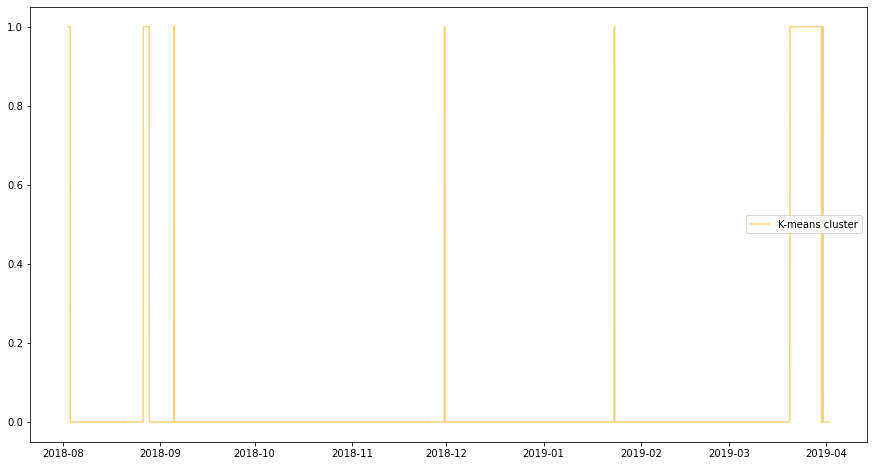

In [40]:
plt.figure(figsize=(15,8))

kmeans_test = pd.DataFrame(pc_test_clusters[0].replace({2:0})).replace({3:0}).set_index(test.index)

plt.plot(kmeans_test, color='orange', alpha=0.5, label='K-means cluster')
plt.legend()

Here we can visualize the times when the anomalies occurred in the test set according to the K-means model.

# Semi-supervised models

The following models take into consideration the period without anomalies and the period where the irregular behavior happened.

In general form, the main idea of these models is to understand what is the normal behavior of the data in the train set and later detect the anomalies in the test set.

Following this idea, the preprocessing is going to be trained just with the train set. Thus, the values and visualization of some features like the Principal Components may differ from the ones we had in with the K-means model, where we trained with the entire data set.

## One-Class SVM

The idea behind One-Class SVM is that, given a data set with a number of observations from the same distribution, a hyperplane delimiting this distribution can be used to categorize new observations as either coming from the same distribution, or from a different one.

In [41]:
onesvm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.001)

In [42]:
pipeline = Pipeline([
    ('preprocessing', pca_pipeline),
    ('model', onesvm)
])
pipeline

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('scaler', RobustScaler()),
                                                  ('model',
                                                   FunctionTransformer(func=<function isolation_outliers at 0x0000025CD9C3BA60>))])),
                                 ('pca', PCA())])),
                ('model', OneClassSVM(gamma=0.01, nu=0.001))])

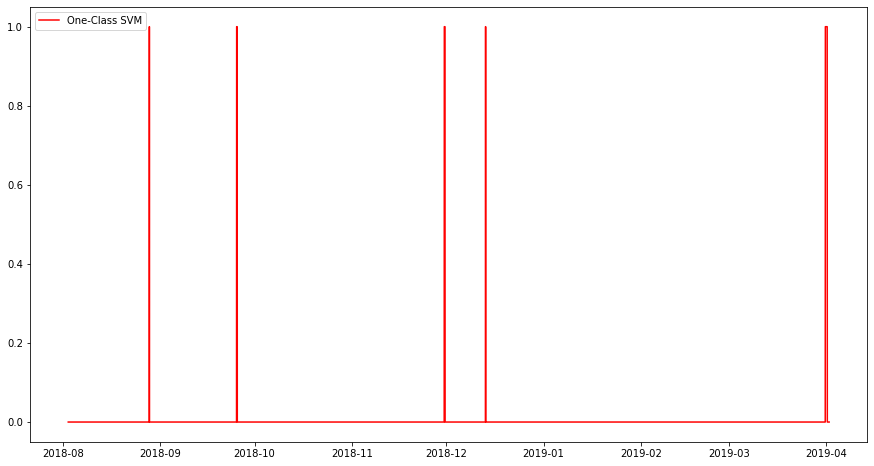

In [43]:
params_one_class_pca = {'model': onesvm, 'preprocessing__pca': pca, 'preprocessing__pca__n_components': 9, 'model__gamma': 0.0001, 'model__nu': 0.001}

pipeline.set_params(**params_one_class_pca)

pipeline.fit(train)

pca_one_class_test = pd.DataFrame(pipeline.predict(test)).replace(1,0).replace(-1,1).set_index(test.index)

plt.figure(figsize=(15,8))

plt.plot(pca_one_class_test, color='r', label='One-Class SVM')

plt.legend()

## Local Outlier Factor

The main objective of the Local Outlier Factor model for novelty detection is measuring the degree of abnormality of the observations by comparing their local density deviation with respect to their neighbors.

The advantage of this method is that it considers both local and global properties of the datasets. The result is not obtained determining how isolated the sample is by itself but compared to the closest other samples.

In [44]:
lof = LocalOutlierFactor(novelty=True)

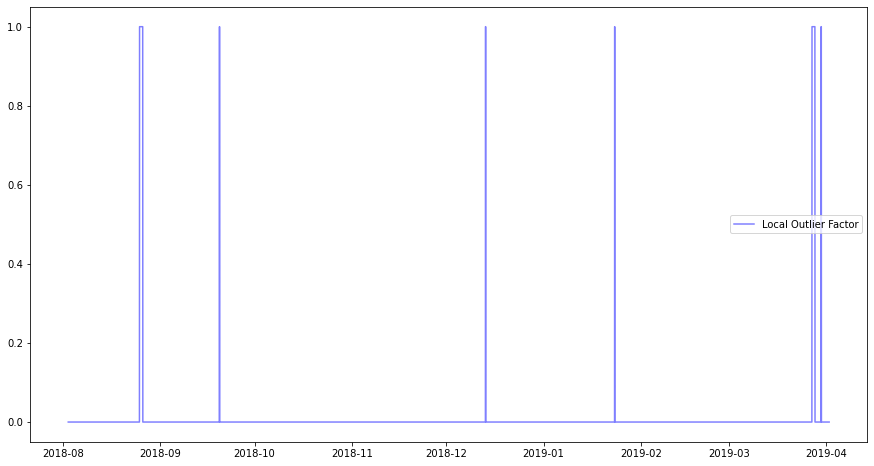

In [45]:
params_local = {'model': lof, 'model__contamination': 0.001, 'preprocessing__pca__n_components': 9}

pipeline.set_params(**params_local)

pipeline.fit(train)

local_pred = pd.DataFrame(pipeline.predict(test)).replace(1,0).replace(-1,1).set_index(test.index)

plt.figure(figsize=(15,8))
plt.plot(local_pred, color='b', alpha=0.5, label='Local Outlier Factor')

plt.legend()

# Results

We are going to present a visualization with the anomalies the three models detect and compare if the results converge on the same moments.

Text(0.5, 1.0, 'All the models')

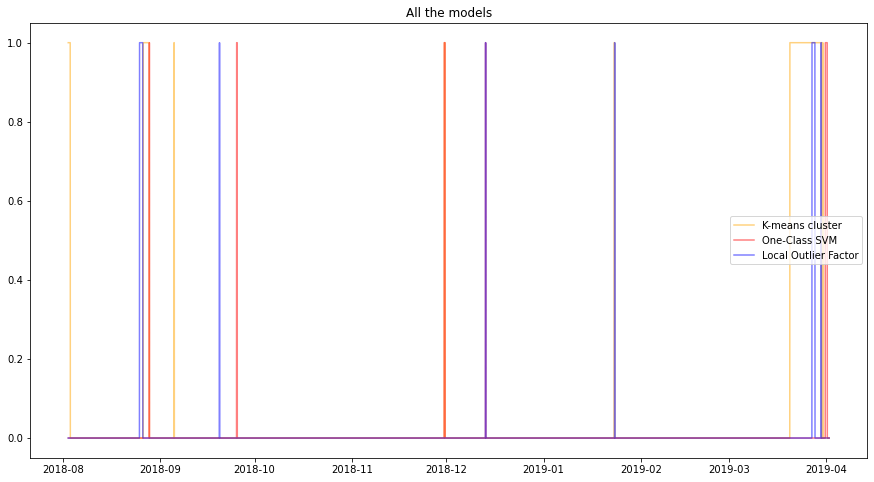

In [46]:
plt.figure(figsize=(15,8))

plt.plot(kmeans_test, color='orange', alpha=0.5, label='K-means cluster')
plt.plot(pca_one_class_test, color='r', label='One-Class SVM', alpha=0.5)
plt.plot(local_pred, color='b', alpha=0.5, label='Local Outlier Factor')

plt.legend()

plt.title('All the models')

- At the beginning of the period (August, 2018), the K-means detect a group of hours with an anomalous behaviour.

- At the end of August, 2018, the three models detect an anomaly happening in a group of hours, being the Local Outlier Factor model the one that detects the problem first.

- In September, 2018, the three models detect problems in three different moments.

- Close to the beginning of December, 2018, the K-means and the One-Class SVM models detect a problem at the same hours.

- In December, 2018, the One-Class SVM and the Local Outlier Factor models detect an anomaly at the same hours.

- In January, 2019, the K-means and the Local Outlier Factor models detect an anomaly at the same hours.

- Finally, at the end of March and the beginning of April, the three models detect a period with several hours having anomalies, being the K-means model the one that detects the problem the first. Our main hypothesis is that an important problem occured to the machine in this period.

Even though we do not have accuracy metrics to compare the results between the different models, we recommend using the K-means model to detect the anomalies, since it predicts almost the same anomalies as the other models but faster in some cases, especially at the end of March, where we suspect the biggest failure happened. The hours of difference could be very valuable for the company to fix the existing problem sooner.

Text(0.5, 0, 'PC3')

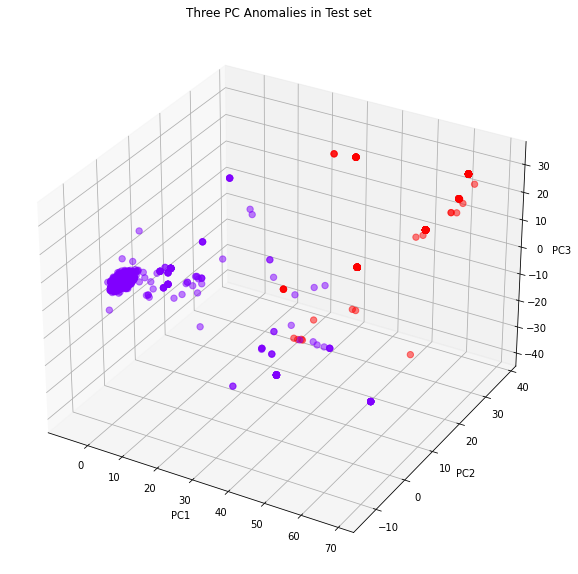

In [47]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection ='3d')
ax.scatter(pc_test[0], pc_test[1], pc_test[2], c=kmeans_test, cmap='rainbow', s = 40, marker = 'o',alpha = 0.5)

plt.title('Three PC Anomalies in Test set')
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.set_zlabel('PC3')

Representation of the detected anomalies in the test set in a 3 dimensional plot with the first three PCs.

In [48]:
final_prediction = kmeans_test.loc[kmeans_test[0] == 1]

In [49]:
final_prediction.rename(columns={0:'Anomalies'}, inplace=True)

In [50]:
final_prediction.count()

Anomalies    321
dtype: int64

The model predicts a total of 321 hours having anomalies.

In [51]:
final_prediction

,Anomalies
datetime,
2018-08-02 16:00:00,1
2018-08-02 17:00:00,1
2018-08-02 18:00:00,1
2018-08-02 19:00:00,1
2018-08-02 20:00:00,1
...,...
2019-03-30 10:00:00,1
2019-03-30 11:00:00,1
2019-03-30 12:00:00,1
